In [8]:
# L 4-22-25

# 1_Explore_Metadata.ipynb

Saved 49598 valid tracks to ../data/valid_track_genres.csv


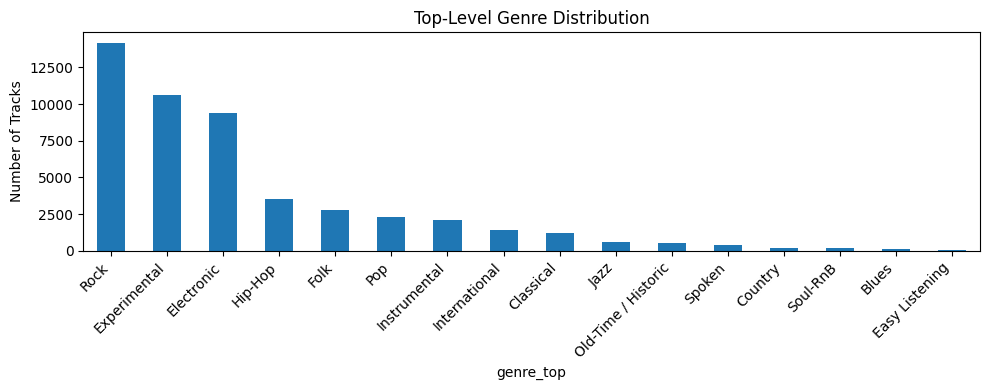

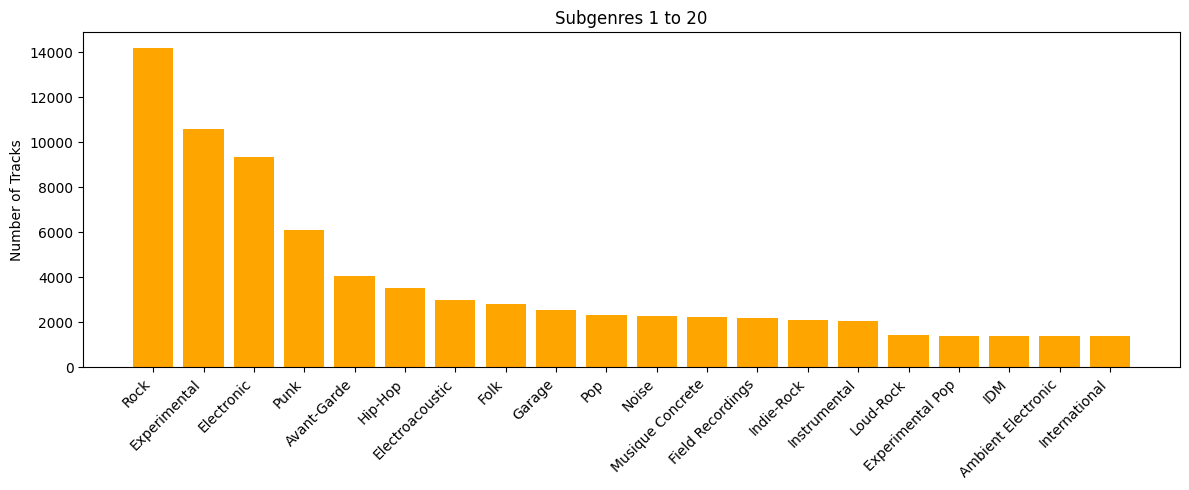

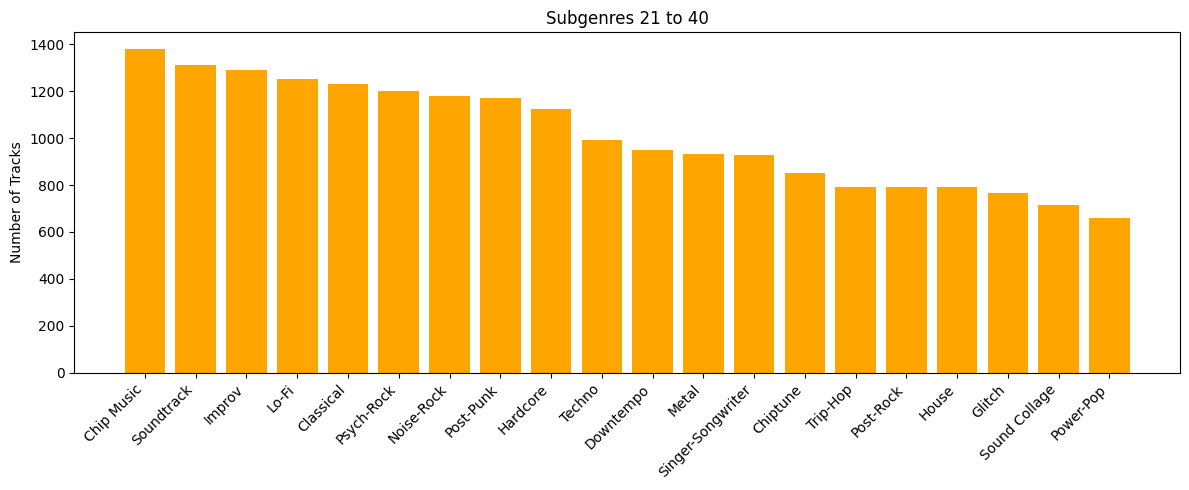

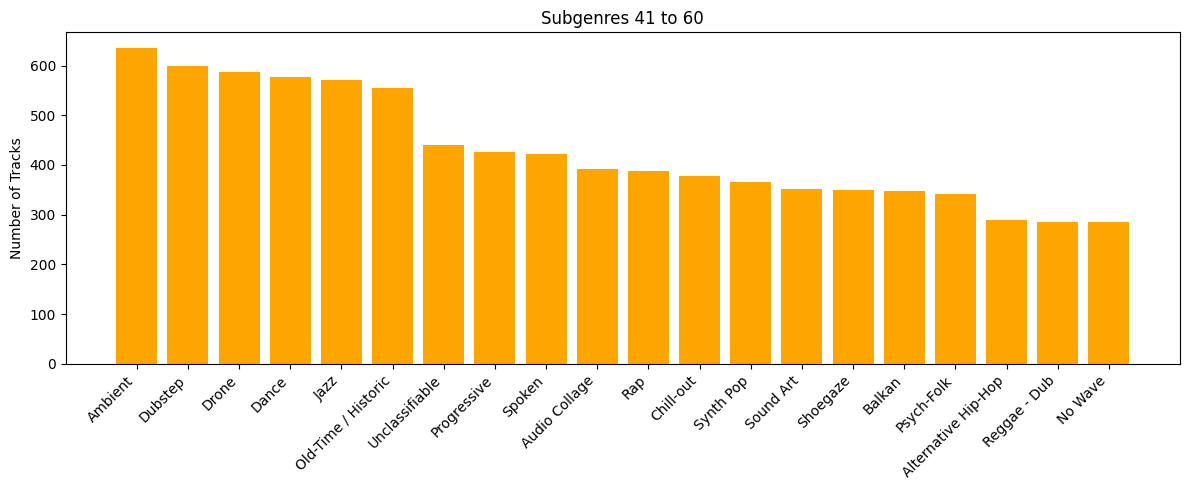

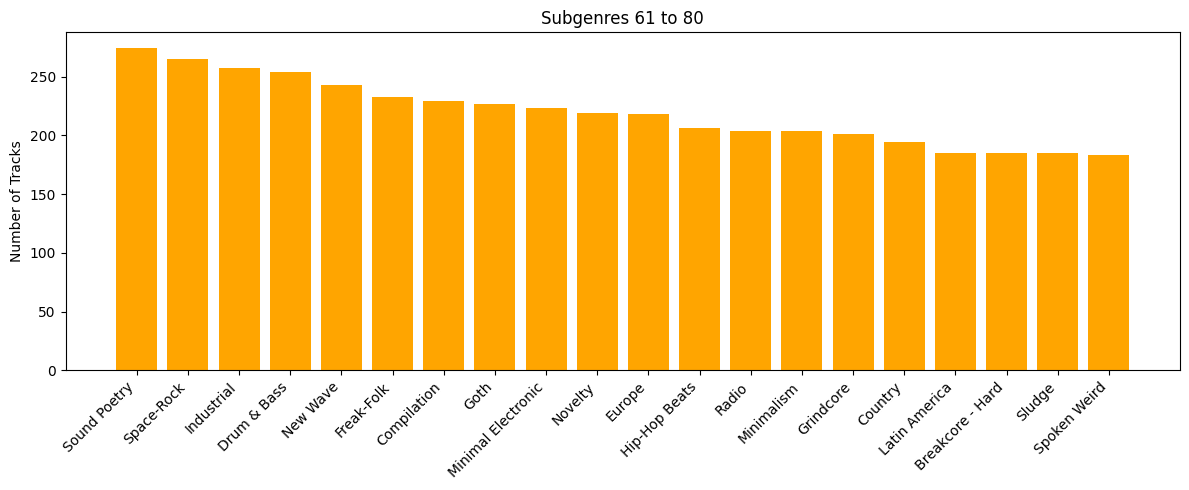

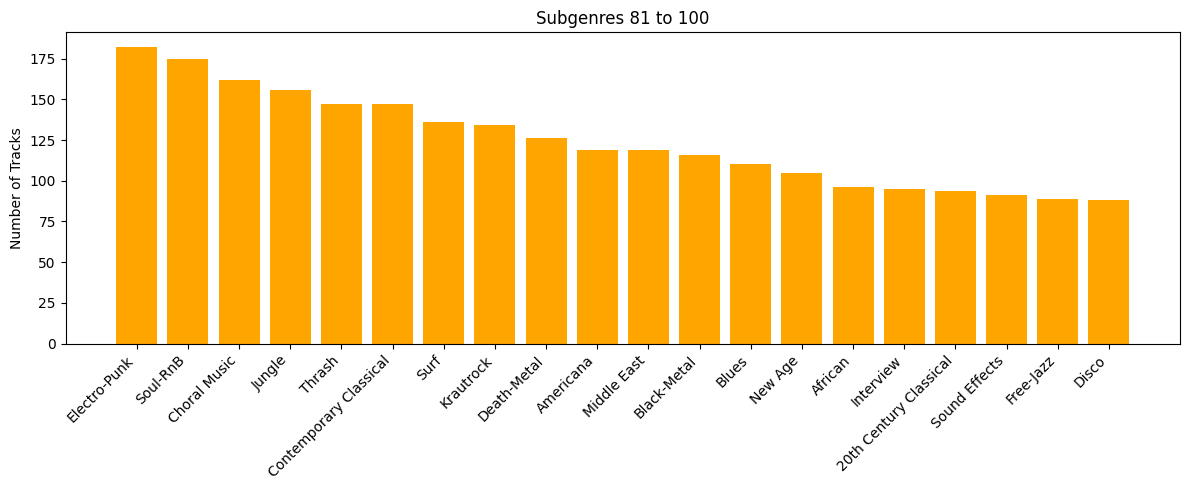

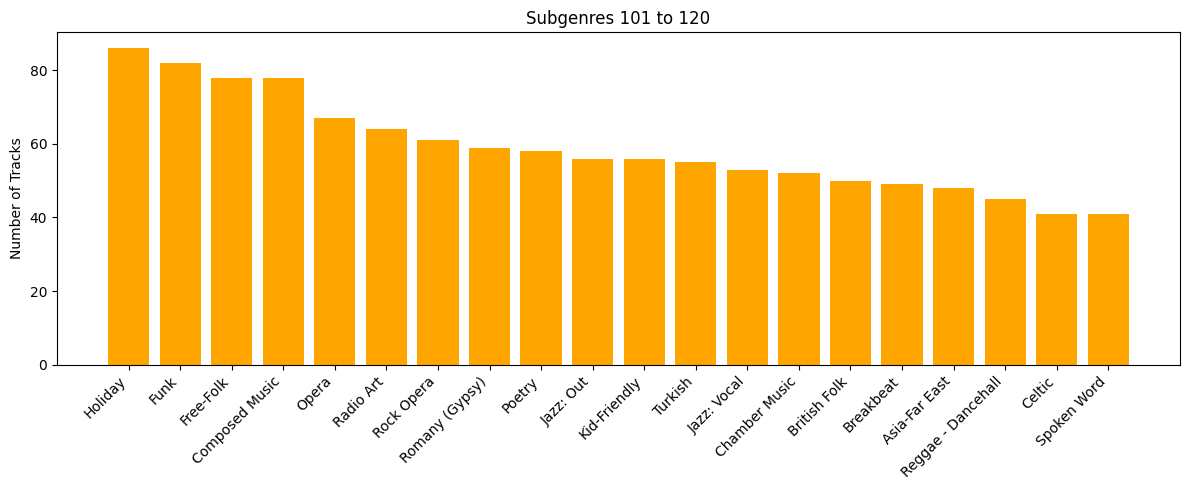

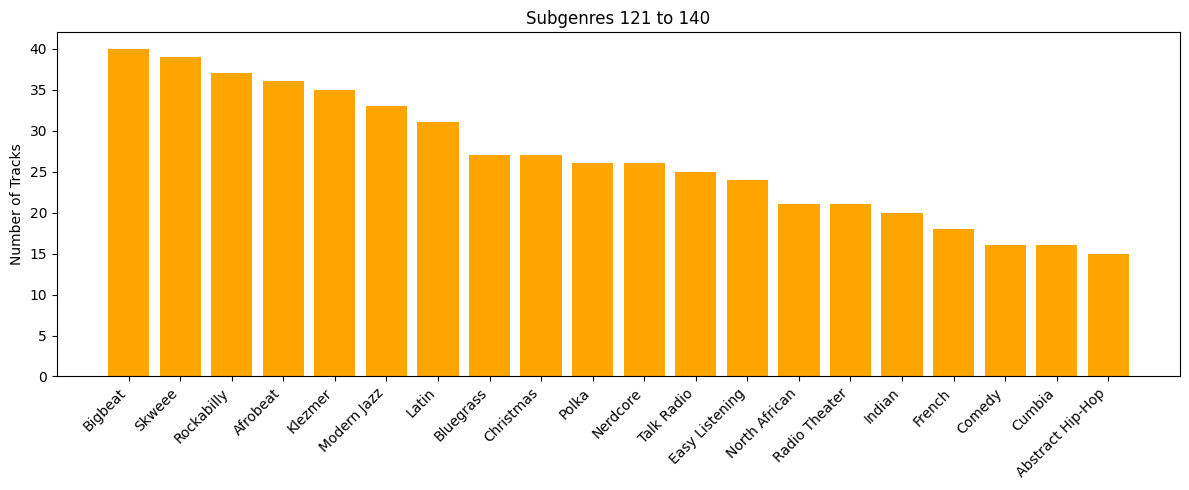

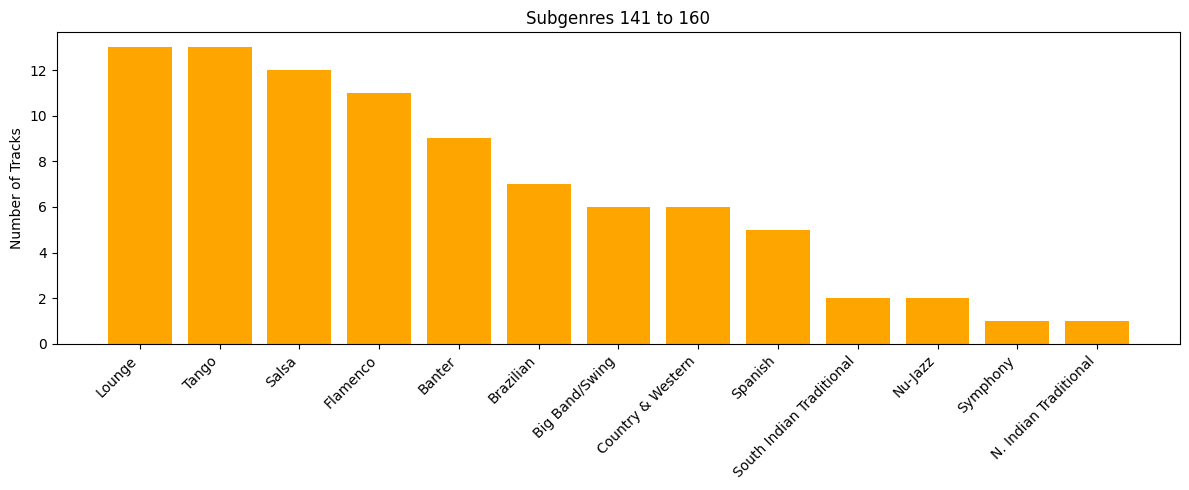

In [26]:
from math import ceil
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import ast
import os

# Load metadata files


def load_metadata():
    tracks = pd.read_csv('../data/fma_metadata/tracks.csv',
                         index_col=0, header=[0, 1])
    genres = pd.read_csv('../data/fma_metadata/genres.csv')
    return tracks, genres

# Create lookup dictionaries for genre IDs


def build_genre_maps(genres):
    genre_id_to_title = dict(zip(genres['genre_id'], genres['title']))
    genre_id_to_top = dict(zip(genres['genre_id'], genres['top_level']))
    genre_id_to_parent = dict(zip(genres['genre_id'], genres['parent']))
    return genre_id_to_title, genre_id_to_top, genre_id_to_parent

# Convert stringified lists like "[21, 76]" into actual Python lists


def parse_genre_ids(cell):
    try:
        return ast.literal_eval(cell)
    except Exception:
        return []

# Map genre IDs to their titles


def map_genre_ids_to_titles(genre_ids, genre_id_to_title):
    titles = []
    for genre_id in genre_ids:
        title = genre_id_to_title.get(genre_id, 'Unknown')
        titles.append(title)
    return titles

# Map genre IDs to their top-level titles


def map_genre_ids_to_top_titles(genre_ids, genre_id_to_top, genre_id_to_title):
    top_titles = set()
    for genre_id in genre_ids:
        top_id = genre_id_to_top.get(genre_id)
        top_title = genre_id_to_title.get(top_id, 'Unknown')
        top_titles.add(top_title)
    return list(top_titles)

# Build the cleaned genre DataFrame


def create_genre_dataframe(tracks, genre_id_to_title, genre_id_to_top):
    all_genres = tracks['track', 'genres_all'].apply(parse_genre_ids)
    genre_top = tracks['track', 'genre_top']
    track_ids = tracks.index

    subgenres = []
    top_levels = []

    for ids in all_genres:
        subgenres.append(map_genre_ids_to_titles(ids, genre_id_to_title))
        top_levels.append(map_genre_ids_to_top_titles(
            ids, genre_id_to_top, genre_id_to_title))

    df = pd.DataFrame({
        'track_id': track_ids,
        'genre_top': genre_top,
        'subgenres': subgenres,
        'top_level_genres': top_levels
    })

    df = df[df['genre_top'].notna()].reset_index(drop=True)
    return df

# Save genre DataFrame to CSV


def save_genre_csv(df):
    os.makedirs("../data", exist_ok=True)
    df.to_csv("../data/valid_track_genres.csv", index=False)
    print(f"Saved {len(df)} valid tracks to ../data/valid_track_genres.csv")

# Create and return path to save plots


def setup_report_folder():
    report_dir = os.path.abspath(os.path.join(
        os.getcwd(), "../reports/Explore_Metadata"))
    os.makedirs(report_dir, exist_ok=True)
    return report_dir

# Plot and save top-level genre bar chart


def plot_top_level_genres(df, report_dir):
    plt.figure(figsize=(10, 4))
    df['genre_top'].value_counts().plot(kind='bar')
    plt.title("Top-Level Genre Distribution")
    plt.ylabel("Number of Tracks")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(report_dir, "top_level_genres.png"))
    plt.show()

# Plot and save all subgenres in chunks


def plot_subgenre_chunks(df, report_dir, chunk_size=20):
    all_genres = []
    for genre_list in df['subgenres']:
        all_genres.extend(genre_list)

    subgenre_counts = Counter(all_genres)
    sorted_subgenres = sorted(subgenre_counts.items(),
                              key=lambda x: x[1], reverse=True)
    num_chunks = ceil(len(sorted_subgenres) / chunk_size)

    for i in range(num_chunks):
        chunk = sorted_subgenres[i * chunk_size:(i + 1) * chunk_size]
        labels, values = zip(*chunk)

        plt.figure(figsize=(12, 5))
        plt.bar(labels, values, color='orange', align='center')
        plt.title(f"Subgenres {i * chunk_size + 1} to {(i + 1) * chunk_size}")
        plt.ylabel("Number of Tracks")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()

        filename = f"subgenres_{i * chunk_size + 1}_to_{(i + 1) * chunk_size}.png"
        plt.savefig(os.path.join(report_dir, filename))
        plt.show()

# Main pipeline


def main():
    tracks, genres = load_metadata()
    genre_id_to_title, genre_id_to_top, genre_id_to_parent = build_genre_maps(
        genres)
    df_genres = create_genre_dataframe(
        tracks, genre_id_to_title, genre_id_to_top)
    save_genre_csv(df_genres)

    report_dir = setup_report_folder()
    plot_top_level_genres(df_genres, report_dir)
    plot_subgenre_chunks(df_genres, report_dir)


if __name__ == "__main__":
    main()